In [138]:
import numpy as np
import pandas as pd

In [139]:
# Read data
df1 = pd.read_json('../Data/domain1_train_data.json', lines=True)
df2 = pd.read_json('../Data/domain2_train_data.json', lines=True)
df1['domain'], df2['domain'] = 0, 1

In [140]:
txt_1_0 = [len(txt) for txt in df1[df1['label']==0]['text']]
txt_1_1 = [len(txt) for txt in df1[df1['label']==1]['text']]

txt_2_0 = [len(txt) for txt in df2[df2['label']==0]['text']]
txt_2_1 = [len(txt) for txt in df2[df2['label']==1]['text']]

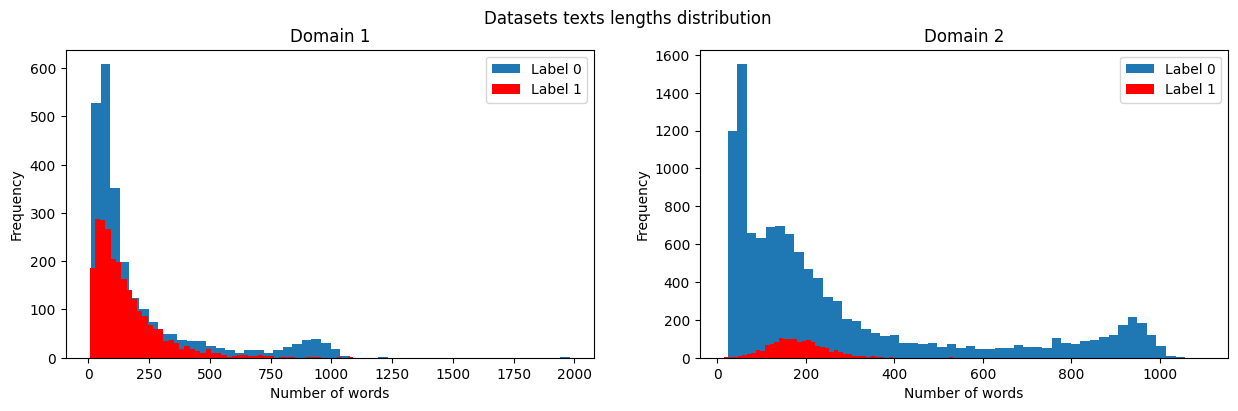

In [141]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(15, 4))
fig.suptitle('Datasets texts lengths distribution')
for i in range(0,2):
    if i == 0: 
        axs[i].hist(txt_1_0, bins=50)
        axs[i].hist(txt_1_1, bins=50, color='r')
        axs[i].set_title('Domain 1')
    else:
        axs[i].hist(txt_2_0, bins=50)
        axs[i].hist(txt_2_1, bins=50, color='r')
        axs[i].set_title('Domain 2')
    axs[i].set_xlabel('Number of words')
    axs[i].set_ylabel('Frequency')
    axs[i].legend(['Label 0','Label 1'])
plt.show()

In [172]:
from sklearn.model_selection import train_test_split
# Train dev split
df1_train, df1_dev = train_test_split(df1, stratify=df1['label'], random_state=42)
df2_train, df2_dev = train_test_split(df2, stratify=df2['label'], random_state=42)

# Join data in both domains for trating them jointly (Augmentation)
df_train = pd.concat([df1_train, df2_train]).reset_index(drop=True)
df_dev = pd.concat([df1_dev, df2_dev]).reset_index(drop=True)

print(f'The class proportions are: {df_train.domain.value_counts()/df_train.shape[0]}')

The class proportions are: domain
1    0.722222
0    0.277778
Name: count, dtype: float64


In [175]:
import re
from sklearn.feature_extraction.text import CountVectorizer
# List to strings
tr_text = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in df_train['text']]
ts_text = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in df_dev['text']]

# Tokens encoding to sparce matrix (Countv)
cvec = CountVectorizer()
X_tr = cvec.fit_transform(tr_text)
X_ts = cvec.transform(ts_text)

y_train = df_train['domain']
y_test = df_dev['domain']

In [176]:
# Data oversampling
from imblearn.over_sampling import RandomOverSampler

# transform the dataset
oversample = RandomOverSampler()
X, y = oversample.fit_resample(X_tr, y_train)

print(f'The class proportions are: {y.value_counts()/len(y)}')

The class proportions are: domain
0    0.5
1    0.5
Name: count, dtype: float64


# Classification Model for domain prediction

In [177]:
from sklearn.linear_model import LogisticRegression
cl_c = LogisticRegression(max_iter=100000).fit(X_tr, y_train)

In [178]:
from sklearn.metrics import f1_score
print(f'Train Accuracy {cl_c.score(X_tr, y_train):.3f}\t Train F1 {f1_score(y_train,cl_c.predict(X_tr)):.3f}')
print(f'Test Accuracy {cl_c.score(X_ts, y_test):.3f}\t Test F1 {f1_score(y_test,cl_c.predict(X_ts)):.3f}')

Train Accuracy 1.000	 Train F1 1.000
Test Accuracy 0.997	 Test F1 0.998


In [179]:
import warnings
from sklearn.model_selection import GridSearchCV 
warnings.filterwarnings('ignore')

# defining parameter range 
param_grid = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1, 10, 100]}]
  
grid = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_tr, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END ..................solver=newton-cg;, score=0.998 total time=   0.4s
[CV 2/5] END ..................solver=newton-cg;, score=0.997 total time=   0.3s
[CV 3/5] END ..................solver=newton-cg;, score=0.996 total time=   0.5s
[CV 4/5] END ..................solver=newton-cg;, score=0.999 total time=   0.4s
[CV 5/5] END ..................solver=newton-cg;, score=0.998 total time=   0.4s
[CV 1/5] END ......................solver=lbfgs;, score=0.998 total time=   0.3s
[CV 2/5] END ......................solver=lbfgs;, score=0.997 total time=   0.3s
[CV 3/5] END ......................solver=lbfgs;, score=0.996 total time=   0.3s
[CV 4/5] END ......................solver=lbfgs;, score=0.999 total time=   0.3s
[CV 5/5] END ......................solver=lbfgs;, score=0.998 total time=   0.3s
[CV 1/5] END ..................solver=liblinear;, score=0.998 total time=   0.6s
[CV 2/5] END ..................solver=liblinear;

GridSearchCV(estimator=LogisticRegression(),
             param_grid=[{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']},
                         {'penalty': ['none', 'elasticnet', 'l1', 'l2']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100]}],
             verbose=3)

In [180]:
from sklearn.metrics import classification_report 
grid_predictions = grid.predict(X_ts) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1250
           1       1.00      1.00      1.00      3250

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500



# Save model

In [181]:
import pickle
# save model
with open('../saved models/Domain_class_model.pkl','wb') as f:
    pickle.dump(cl_c,f)

# Save countVect
with open('../saved models/objs.pkl', 'wb') as f:
    pickle.dump([cvec], f)